# Intro to Regularization



In [24]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold

%matplotlib inline

/Users/julialintern/anaconda/envs/mypython3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Regularized Regression with sklearn
As we've discussed, **regularization** is basically a blanket term for any technique that alters a model to prevent **overfitting**.  In linear regression, this is generally done by adding a term to the **Cost function** that is increasing in the absolute value of the coefficients.  The upshot of this is that models with large coefficients are implicitly punished by increasing their cost function, and the underlying mathematics of regression seek to choose the model that minimizes the value of the cost function.

There are 2 very common regularization techniques for regression, called **"Ridge Regression"** and **"Lasso Regression"**

##### Ridge Regression
[Ridge Regression](http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression) adds the L2 norm (square root of the sum of squares) of the coefficients to the cost function.

##### Lasso Regression
[Lasso Regression](http://scikit-learn.org/stable/modules/linear_model.html#lasso) adds the L1 norm (sum of absolute values) of the coefficients to the cost function.

##### ElasticNet Regression
[ElasticNet Regression](http://scikit-learn.org/stable/modules/linear_model.html#elastic-net) simply combines both by adding **both** the **L1** and **L2** norm seeking the best of both worlds.

sklearn has specific model types for both of the above regressions which we will see some of below.  Essentially, there is a "punishment parameter" alpha that these models try several different values of with cross-validation and then they return the value and model that yields the best generalization.  The beauty of this is that it all (optionally) happens completely under the covers!  We will use **RidgeCV** later in the exercises to perform regression with automatic Regularization and Cross-Validation.

## Polynomial Regression Revisited
To see how to use Regularized Regression we're going to revisit our generated data which we were using to fit polynomial regressions.

#### Reload the Data
Let's reload the `X` and `y` numpy arrays as follows:

In [2]:
# Load the file
npz = np.load('../../week02-luther1/03-regression_statsmodels/data/poly_data.npz')
# Retrieve each array
X = npz['arr_0']
y = npz['arr_1']


### Visualizing Overfitting: The need for Regularization
Now that we have our data again we're going to train some increasingly complex (increasing degree) polynomials and watch what happens to the training and test errors as complexity increases.  Let's take a look at the data as we did before except this time we'll split into a train and test set first via `train_test_split`.

Don't worry about the `sklearn` details of this right now, the **focus is on regularization**.  Essentially, we're training our model against one set and then testing it against some previously unknown set.

Now we're ready to see what happens as we increase the degree of our polynomials and fit each one.  The below code will generate a plot of the error as a function of polynomial degree for degree 1-9:

In [4]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

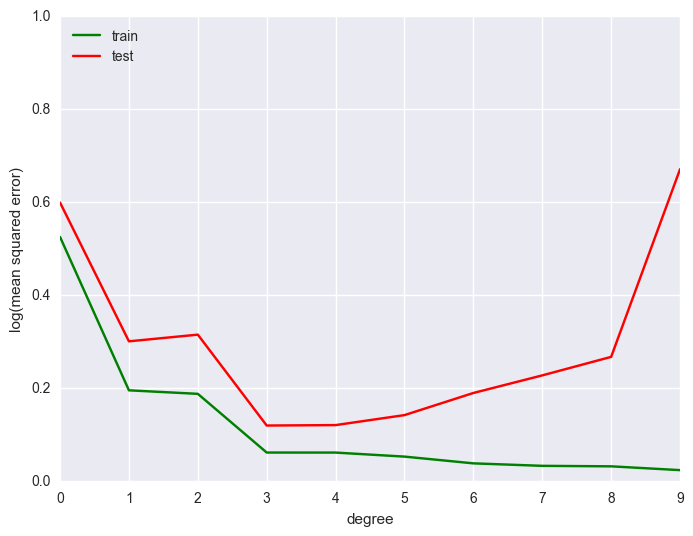

In [5]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error

# Step through degrees from 0 to 9 and store the training and test (generalization) error.
# create array of zeros,
train_error = np.empty(10)
test_error = np.empty(10)
for degree in range(10):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

# Plot the training and test errors against degree
plt.figure(figsize=(8,6))
plt.plot(np.arange(10), train_error, color='green', label='train')
plt.plot(np.arange(10), test_error, color='red', label='test')
plt.ylim((0.0, 1e0))
plt.ylabel('log(mean squared error)')
plt.xlabel('degree')
plt.legend(loc='upper left')


**What do you notice?**

The higher the degree of the polynomial (our proxy for model complexity), the lower the training error. The testing error decreases too, but it eventually reaches its minimum at a degree of three and then starts increasing at a degree of seven. 

This is a visual demonstration of ***overfitting***: the model is already so complex that it fits the idiosyncrasies of our training data, idiosyncrasies which limit the model's ability to generalize (as measured by the testing error).

In the above example, the optimal choice for the degree of the polynomial approximation would be between three and six. So when we get some data, we could fit a bunch of polynomials and then choose the one that minimizes MSE.

### Visualizing Regularized Regression

#### Hand picking polynomials is hard work, and data scientists are lazy so....
...we would like a method that eliminates the need to manually select the degree of the polynomial: we can add a constraint to our linear regression model that constrains the magnitude of the coefficients in the regression model. This constraint is called the regularization term and the technique is often called shrinkage in the statistical community because it shrinks the coefficients towards zero. In the context of polynomial regression, constraining the magnitude of the regression coefficients effectively is a smoothness assumption: by constraining the L2 norm of the regression coefficients we express our preference for smooth functions rather than wiggly functions.

A popular regularized linear regression model is Ridge Regression. This adds the L2 norm of the coefficients to the ordinary least squares objective:

  $J(\boldsymbol\beta) = \frac{1}{n}\sum_{i=0}^n (y_i - \boldsymbol\beta^T \mathbf{x}_i')^2 + \alpha \|\boldsymbol\beta\|_2$

where $\boldsymbol\beta$ is the vector of coefficients including the intercept term and $\mathbf{x}_i'$ is the i-th feature fector including a dummy feature for the intercept. The L2 norm term is weighted by a regularization parameter ``alpha``: if ``alpha=0`` then you recover the Ordinary Least Squares regression model. The larger the value of ``alpha`` the higher the smoothness constraint.

Below you can see the approximation of a [``sklearn.linear_model.Ridge``](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) estimator fitting a polynomial of degree nine for various values of ``alpha`` (left) and the corresponding coefficient loadings (right). The smaller the value of ``alpha`` the higher the magnitude of the coefficients, so the functions we can model can be more and more wiggly. 

In [6]:
# Bringing in our helper functions

def f(x):
    return np.sin(2 * np.pi * x)

def plot_approximation(est, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
    ax.scatter(X, y, s=100)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right',frameon=True)

x_plot = np.linspace(0, 1, 100)

In [ ]:
from sklearn.linear_model import Ridge

# Set up a figure and axes for 8 plots, 2 per row for 4 rows
fig, ax_rows = plt.subplots(4, 2, figsize=(15, 20))

# A helper function to plot the absolute value of the coefficients on the right-hand column plot
def plot_coefficients(est, ax, label=None, yscale='log'):
    coef = est.steps[-1][1].coef_.ravel()
    if yscale == 'log':
        ax.semilogy(np.abs(coef), marker='o', label=label)
        ax.set_ylim((1e-1, 1e8))
    else:
        ax.plot(np.abs(coef), marker='o', label=label)
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.set_xlim((1, 9))
    ax.set_ylim(-1000,1e6)

# Try out 4 different values of the RidgeRegression parameter alpha and watch how the resulting models change
# With higher values of alpha, more complex (more wiggly) models will be more punished and thus less likely
degree = 9
alphas = [0.0, 1e-8, 1e-5, 1]
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='Ridge(alpha=%r) coefficients' % alpha)

plt.tight_layout()

##### Now with the LASSO...

In the above example we used Ridge Regression, a regularized linear regression technique that puts an [L2 norm](http://mathworld.wolfram.com/L2-Norm.html) penalty on the regression coefficients. As mentioned above, another popular regularization technique is the LASSO, a technique which puts an [L1 norm](http://mathworld.wolfram.com/L1-Norm.html) penalty instead. The difference between the two is that the LASSO leads to sparse solutions, driving most coefficients to zero, whereas Ridge Regression leads to dense solutions, in which most coefficients are non-zero.

Let's check out the same process using the LASSO:

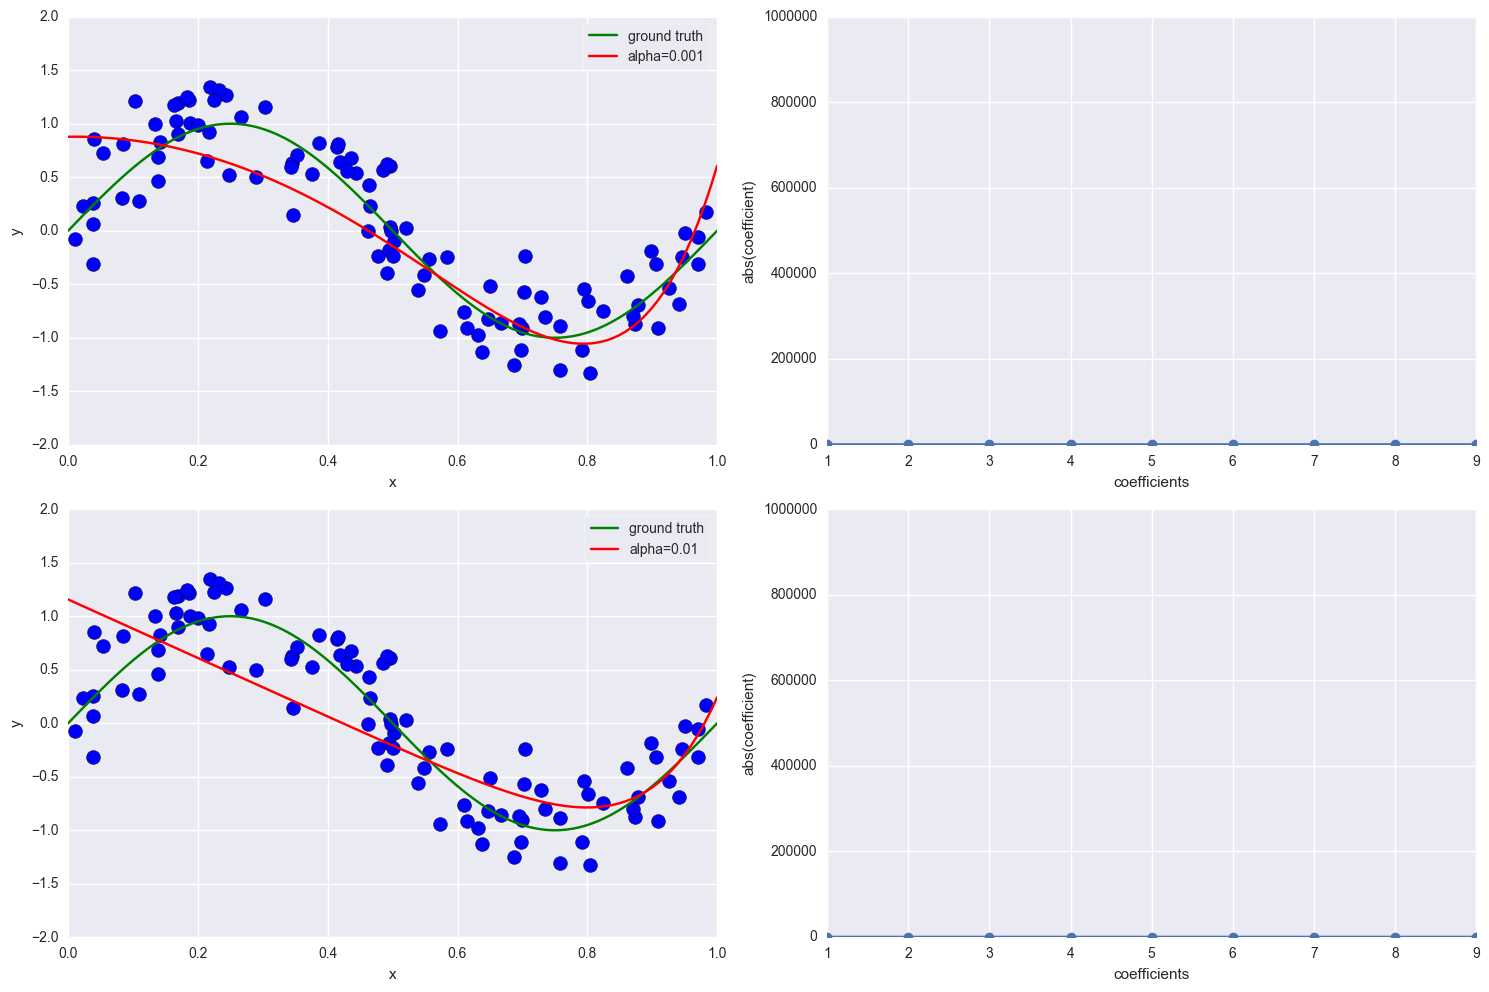

In [12]:
from sklearn.linear_model import Lasso

# Create only 2 plot rows, only trying 2 alphas
fig, ax_rows = plt.subplots(2, 2, figsize=(15, 10))

# Plot the results next to the coefficient values for each of hte 2 alphas
degree = 9
alphas = [1e-3, 1e-2]
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha))
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='Lasso(alpha=%r) coefficients' % alpha, yscale=None)

plt.tight_layout()

Notice that for the Lasso many of the coefficients are zero.  When you choose an sklearn model that encapsulates both Regularization and Cross-Validation (like [**RidgeCV**](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) to be used below for instance) sklearn will choose the best value from several options of ***alpha*** by cross-validating in whatever way you decide.

##### And with ElasticNet...
Remember this tries to find the best of both worlds, with both L1 and L2 regularization:

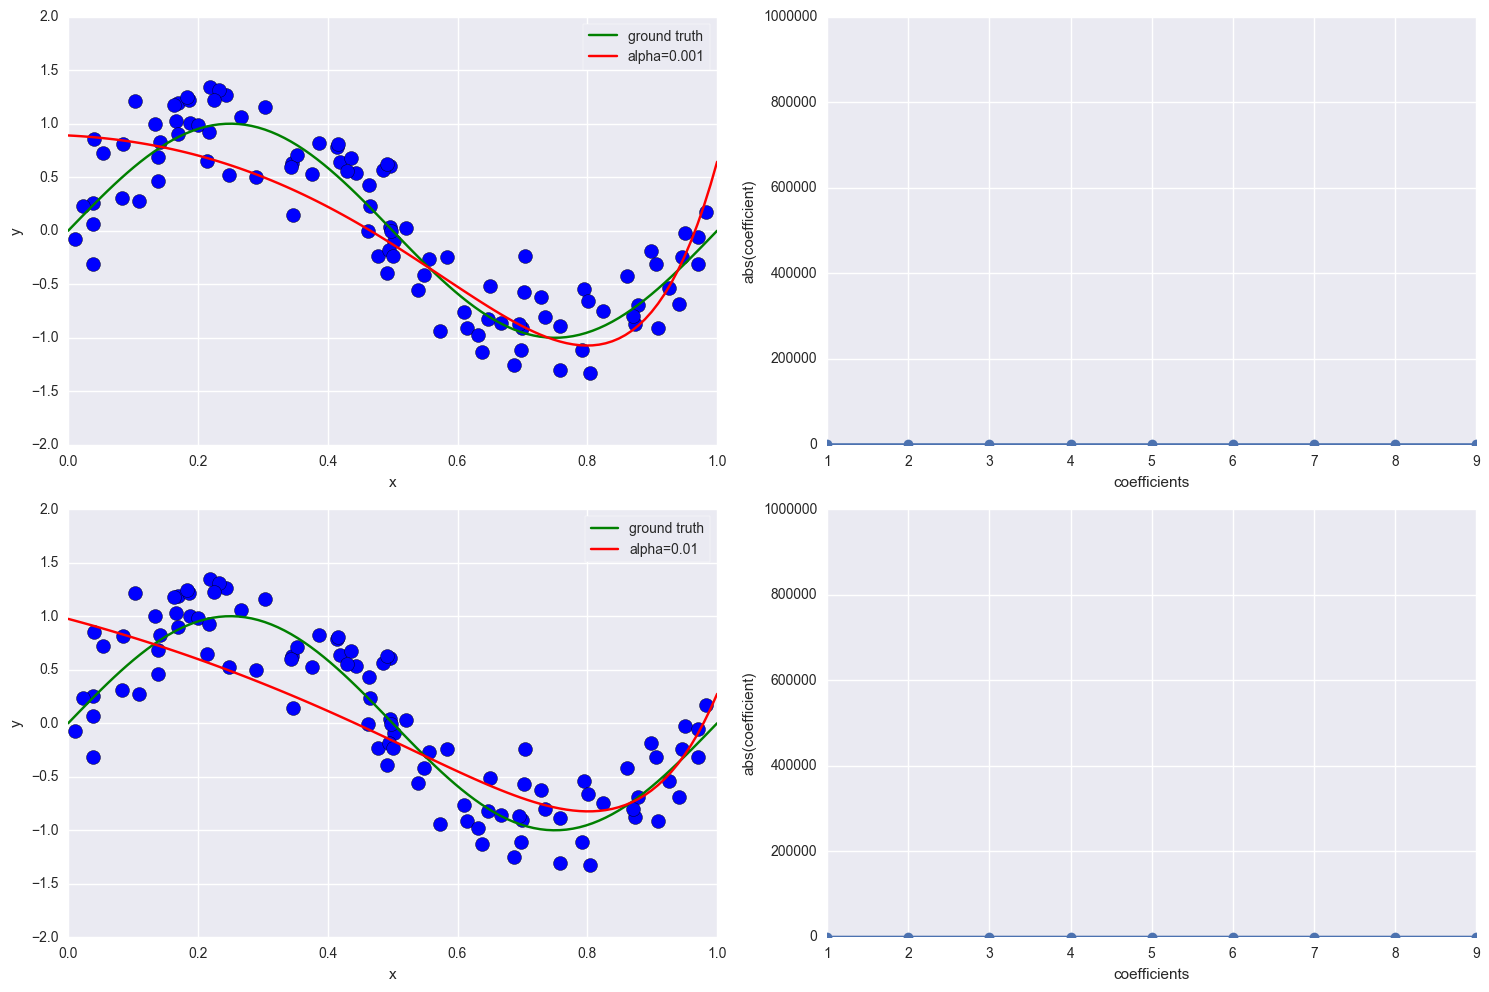

In [13]:
from sklearn.linear_model import ElasticNet

# Create only 2 plot rows, only trying 2 alphas
fig, ax_rows = plt.subplots(2, 2, figsize=(15, 10))

# Plot the results next to the coefficient values for each of hte 2 alphas
degree = 9
alphas = [1e-3, 1e-2]
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), ElasticNet(alpha=alpha))
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='ElasticNet(alpha=%r) coefficients' % alpha, yscale=None)

plt.tight_layout()

Notice that this is some sort of hybrid of the look/feel of the Lasso and Ridge!  

Congratulations, you understand regularization!

**Remember:** regularization is a general concept.  It's any adjustment to the actual modeling step that tries to inherently control for overfitting, most often by augmenting the cost function.

In [3]:

# Let's get back to the cars ~ Import the car dataframe via the picklefile again

cars=pd.read_pickle('../../week02-luther1/03-regression_statsmodels/cars2frame.pkl')

cars.head(1)

y_cars=cars['log_price']
X_cars=cars.drop(['log_price','price'],1)

In [4]:
# As we saw before, here is our baseline r^2 score
lr=LinearRegression()

xtrain, xtest, ytrain, ytest = train_test_split(X_cars, y_cars, test_size=0.3)

lr.fit(xtrain, ytrain)
lr.score(xtest, ytest)

0.89122452407498542


### Automatic Cross-Validation with sklearn
So far we've just been using train/test splits for cross-validation and we haven't let sklearn do the work for us.  So here we're going to do both, and we're going to do it in just 3 lines!

First, import sklearn.linear_model.RidgeCV

In [16]:
from sklearn.linear_model import RidgeCV

Now, create a `RidgeCV` object with the parameter `cv` set to 10.  

What this will do is perform [10-fold cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation).  The CV in RidgeCV means that is has this capability built in.  Because this is a Ridge Regressor, it also has regularization built in.  You can check out the [RidgeCV Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) to see the default values it uses for `alpha` (they are configurable as a parameter of course).

In [17]:
rcv = RidgeCV(cv=10)

In [18]:
# now 
# Is there an easier way to do train/test/validation and Ridge Regression altogether?  Of course there is!

rcv.fit(X_cars, y_cars)
rcv.score(xtest, ytest)


0.95109194831555166

Nice!  We've already improved our baseline model and with cross-validation and regularization we have an estimate of our model's future performance that we should feel reasonably comfortable reporting to our boss.


In [15]:
## STUDENT SECTION: 

# Using Ridge, Lasso and/or ElasticNet together with cross-validation, 
# Tune your alpha parameter to determine which alpha minimizes Mean-squared Error
# Plot your results 

## Hint (before you go too far): see the note here about L1 & L2 
# http://scikit-learn.org/stable/modules/preprocessing.html


In [6]:
# first we normalize our features .. 
from sklearn import preprocessing

# normalize features to values between 0 and 1
cars_trans=preprocessing.normalize(cars,axis=0)

# turn back in DF
cars_trans=pd.DataFrame(cars_trans,columns=cars.columns)

y_trans=cars_trans['log_price']
X_trans=cars_trans.drop(['log_price','price'],1)

X_trans.describe()

,length,width,height,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,...,make[T.nissan],make[T.peugot],make[T.plymouth],make[T.porsche],make[T.renault],make[T.saab],make[T.subaru],make[T.toyota],make[T.volkswagen],make[T.volvo]
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.0,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.071430,0.071574,0.071541,0.071375,0.071281,0.066549,0.067254,0.071313,0.069447,0.069926,...,0.021757,0.017008,0.013568,0.010256,0.0,0.012561,0.017765,0.029010,0.017765,0.017008
std,0.005114,0.002317,0.003183,0.005828,0.006889,0.026516,0.024662,0.006548,0.017520,0.015484,...,0.068402,0.069741,0.070495,0.071056,0.0,0.070683,0.069552,0.065641,0.069552,0.069741
min,0.057838,0.065506,0.063490,0.054452,0.045396,0.045693,0.031259,0.058035,0.035579,0.036277,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.068168,0.069580,0.069068,0.067530,0.068204,0.055485,0.045586,0.067125,0.053369,0.056683,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.070996,0.071046,0.071858,0.070960,0.072152,0.058748,0.061867,0.071320,0.068422,0.068019,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.075444,0.072676,0.073917,0.076962,0.074783,0.061359,0.075543,0.076914,0.082106,0.079356,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.085302,0.078216,0.079429,0.084465,0.091450,0.150135,0.170623,0.092297,0.134107,0.122435,...,0.235702,0.301511,0.377964,0.500000,0.0,0.408248,0.288675,0.176777,0.288675,0.301511


In [11]:
from sklearn.linear_model import Ridge

In [54]:
import warnings
warnings.filterwarnings('ignore')

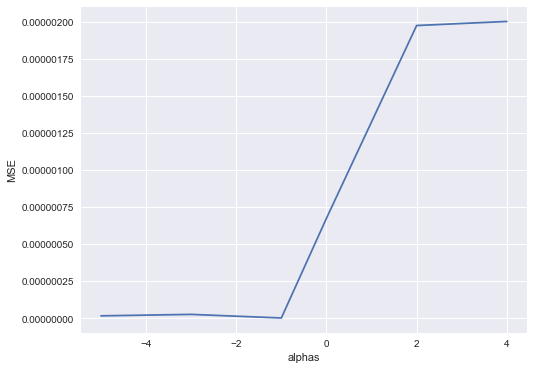

In [82]:
# Test, train, split option via Ridge 
alphas=[1e-5,1e-3,1e-1,1,100,10000]
X_train, X_test, y_train, y_test = train_test_split(X_trans, y_trans, test_size=0.3)

def make_estimator(est,alpha):
    est.alpha=alpha
    model = est.fit(X_train,y_train)
    mse=np.mean(y_test-model.predict(X_test))**2
    return mse
    
# Get scores
all_mse=[]    
for a in alphas:    
    all_mse.append(make_estimator(Ridge(),a))
    

#plot of model
plt.figure(figsize=(8,6))
plt.legend()
plt.plot(np.log10(alphas),all_mse)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()


In [75]:
from sklearn.linear_model import Lasso

In [76]:
# A bit more involved approach: illustrated here with Lasso
kf = KFold(len(X_trans),n_folds=5, shuffle=True)

all_scores=[]
alphas=[1e-5,1e-3,1e-1,0,1,100]
r2=[]

for train, test in kf:
    x_train=X_trans.iloc[train]
    y_train=y_trans.iloc[train]
    x_test=X_trans.iloc[test]
    y_test=y_trans.iloc[test]
    mse_score=[]
    r=[]
    for a in alphas:
        est=Lasso(alpha=a,tol=0.001)
        est.fit(x_train,y_train)
        mse=np.mean((y_test-est.predict(x_test))**2)
        mse_score.append(mse)
        r.append(est.score(x_test,y_test))
    r2.append(r)       
    all_scores.append(mse_score)
#all_scores

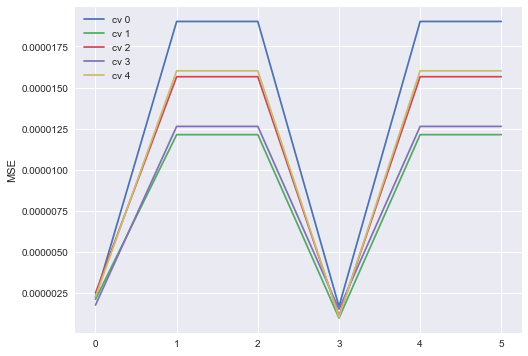

In [77]:
# Which alpha is the best for our model ? Looks like alpha= 0
plt.figure(figsize=(8,6))
#plt.ylim(0,0.1)
plt.legend()
for i in range(5):
    plt.plot(all_scores[i],label = 'cv %s'%i)
    
plt.legend()
plt.ylabel('MSE')
plt.show()


In [81]:
# Take a quick look at our strongest features
X_train, X_test, y_train, y_test = train_test_split(X_trans, y_trans, test_size=0.3)

est=Lasso(alpha=0)
est.fit(X_train,y_train)
est.alpha


zipped=zip(X_cars.columns,est.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)
features[:5]


[('wheel_base', 0.18242663495701872),
 ('curb_weight', 0.17338744275202031),
 ('horsepower', 0.043843561403345881),
 ('highway-mpg', 0.041063571210333334),
 ('bore', 0.016904259612716657)]

In [ ]:
# if we run the above xtest train for feature selection, 
# we might see varying results - -what to do? 
    
    

In [69]:
all_scores=[]
alphas=[1e-5,1e-3,1e-1,0,1,100]
all_features=[]


for train, test in kf:
    x_train=X_trans.iloc[train]
    y_train=y_trans.iloc[train]
    x_test=X_trans.iloc[test]
    y_test=y_trans.iloc[test]
    mse_score=[]
    feat=[]
    for a in alphas:
        
        est=Lasso(alpha=a,tol=0.001)
        est.fit(x_train,y_train)
        mse=np.mean((y_test-est.predict(x_test))**2)
        mse_score.append(mse)
        r2.append(est.score(x_test,y_test))
        zipped=zip(X_cars.columns,est.coef_)
        feat.append(sorted(zipped,key = lambda t: t[1],reverse=True))
        #all_features.append(features)
    all_scores.append(mse_score)
    all_features.append(feat)

In [70]:
all_features[3]

[[('horsepower', 0.05707862458883084),
  ('engine_size', 0.03728396718406049),
  ('make[T.mercedes-benz]', 0.012037113874172122),
  ('make[T.bmw]', 0.0097805095384455015),
  ('make[T.volvo]', 0.0068539968533525156),
  ('make[T.porsche]', 0.0055384036886524891),
  ('make[T.audi]', 0.0044319818165223044),
  ('make[T.saab]', 0.0030407003090535257),
  ('make[T.peugot]', 0.0026679769039762279),
  ('make[T.jaguar]', 0.0021646015368607095),
  ('curb_weight', 0.0012282408504899357),
  ('length', 0.0),
  ('width', 0.0),
  ('height', 0.0),
  ('bore', 0.0),
  ('stroke', 0.0),
  ('compression-ratio', 0.0),
  ('peak-rpm', -0.0),
  ('city-mpg', -0.0),
  ('highway-mpg', -0.0),
  ('wheel_base', 0.0),
  ('Intercept', -0.0),
  ('make[T.isuzu]', -0.0),
  ('make[T.mazda]', 0.0),
  ('make[T.mercury]', 0.0),
  ('make[T.renault]', 0.0),
  ('make[T.subaru]', -0.0),
  ('make[T.toyota]', -0.0),
  ('make[T.volkswagen]', 0.0),
  ('make[T.honda]', -0.00081707563845631809),
  ('make[T.nissan]', -0.00160647691140245

In [ ]:
y_trans = Bx1 + Bx2

In [ ]:
y^2.333 = bx1 + bx2  (take the root across the variables)

y^ 5.344=bx1^2.44 + bx2